In [54]:
import pandas as pd
import numpy as np
import os, glob, cv2
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [56]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "/Users/henricobela/Downloads/dataset/train",
    batch_size=32,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    "/Users/henricobela/Downloads/dataset/validation",
    shuffle=False,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

Found 400 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [57]:
train_generator.class_indices

{'coca': 0, 'fanta': 1}

In [58]:
conv_base = VGG16(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [59]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [61]:
import tensorflow as tf

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [62]:
history = model.fit_generator(generator=train_generator,
                              epochs=10,
                              validation_steps=1,
                              steps_per_epoch=1,
                              validation_data=validation_generator)

/var/folders/0x/lgbrscr56sq1gtx792kyzgvc0000gn/T/ipykernel_2657/3773453766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/10


2023-08-24 15:16:56.943629: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 4s 4s/step - loss: 3.9500 - accuracy: 0.5000 - val_loss: 1.6958 - val_accuracy: 0.6296
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 1.2842 - accuracy: 0.6250 - val_loss: 0.7763 - val_accuracy: 0.7407
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 1.4380 - accuracy: 0.5625 - val_loss: 1.2947 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 1.6691 - accuracy: 0.6562 - val_loss: 0.8526 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 1.4331 - accuracy: 0.6875 - val_loss: 0.7003 - val_accuracy: 0.7407
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.9548 - accuracy: 0.7500 - val_loss: 0.6317 - val_accuracy: 0.7778
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.4126 - accuracy: 0.8750 - val_loss: 0.2712 - val_accuracy: 0.8889
Epoch 8/10
1/1 [==============================] - 5s

In [64]:
model.save('model/model-refri.h5')

model.save_weights('model/weights-refri.h5')
with open('model/architecture-refri.json', 'w') as f:
    f.write(model.to_json())

In [78]:
import cv2

validation_img_paths = ["/Users/henricobela/Downloads/dataset/validation/coca/coca_107.jpeg",
                        "/Users/henricobela/Downloads/dataset/validation/fanta/fanta_101.jpeg",
                        "/Users/henricobela/Downloads/dataset/validation/fanta/fanta_104.jpeg"]

img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [79]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [80]:
pred_probs = model.predict(validation_batch)

1/1 [==============================] - 0s 271ms/step


0.83974993

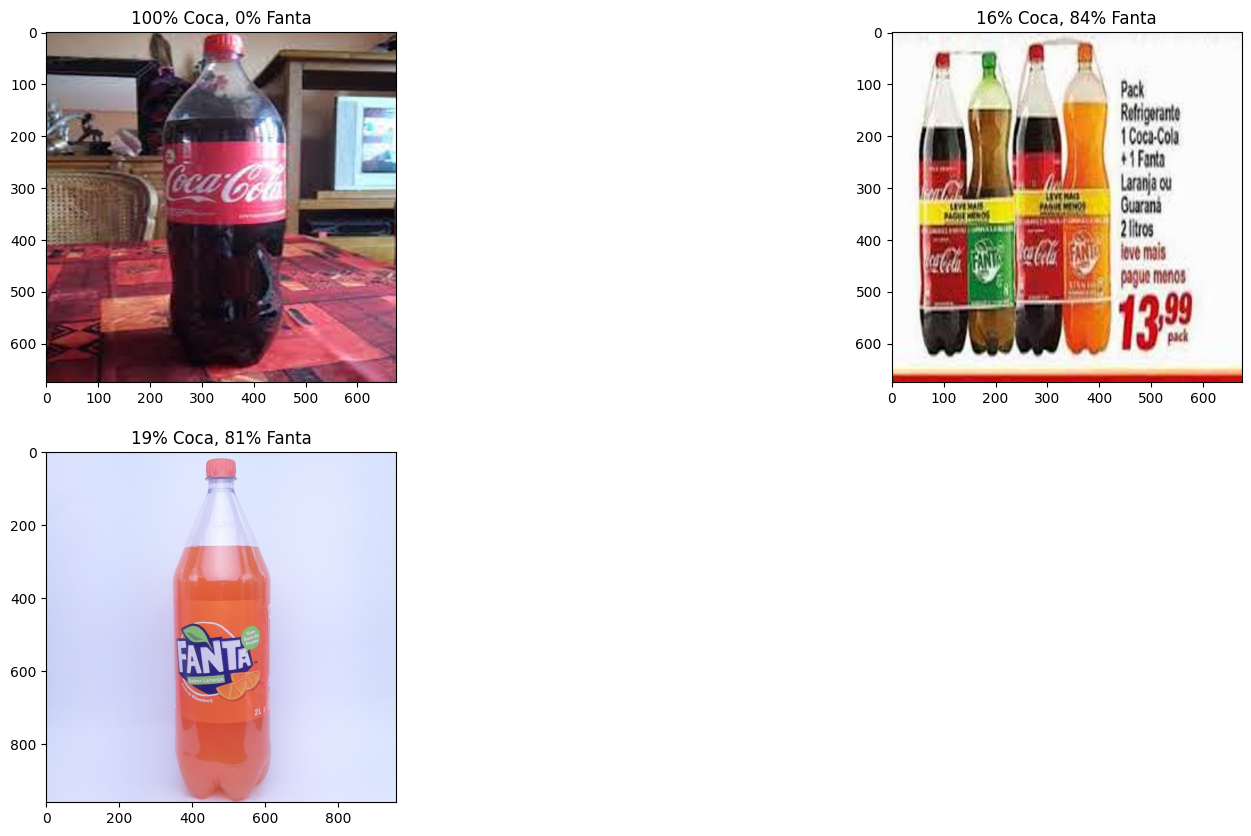

In [81]:
plt.figure(figsize=(20,10))

for i, imagem in enumerate(img_list):
    plt.subplot(2,2,i+1)
    plt.imshow(imagem)
    plt.title("{:.0f}% Coca, {:.0f}% Fanta".format(100*pred_probs[i,0], 100*pred_probs[i,1]))